## Short chunk CNN

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import numpy as np
import json

# Load data from data.json
with open('/content/sample_data/data.json', 'r') as fp:
    data = json.load(fp)

# Extract MFCCs and labels
mfccs = data['mfcc']
labels = data['genre_num']

# Validate and align data
print(f"Original MFCCs length: {len(mfccs)}, Labels length: {len(labels)}")

# Ensure MFCCs and labels have the same number of samples
min_length = min(len(mfccs), len(labels))
mfccs = mfccs[:min_length]
labels = labels[:min_length]
print(f"Aligned MFCCs length: {len(mfccs)}, Labels length: {len(labels)}")

# Convert to NumPy arrays
X = np.array(mfccs)
y = np.array(labels)

# Verify shapes
print(f"X shape: {X.shape}, y shape: {y.shape}")

# Train-validation-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

# Reshape for CNN (add channel dimension)
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]
input_shape = X_train.shape[1:4]
print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}, X_test shape: {X_test.shape}")

# Define Short-chunk CNN model
model_short_cnn = Sequential([
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compile model
model_short_cnn.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train model
model_short_cnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=250,
    callbacks=[early_stopping,lr_scheduler],
    verbose=1
)

# Evaluate on test set
loss, accuracy = model_short_cnn.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Original MFCCs length: 9986, Labels length: 9986
Aligned MFCCs length: 9986, Labels length: 9986
X shape: (9986, 130, 13), y shape: (9986,)
X_train shape: (4893, 130, 13, 1), X_val shape: (2097, 130, 13, 1), X_test shape: (2996, 130, 13, 1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - accuracy: 0.2333 - loss: 2.5864 - val_accuracy: 0.1850 - val_loss: 2.2181 - learning_rate: 1.0000e-04
Epoch 2/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4438 - loss: 1.5927 - val_accuracy: 0.2256 - val_loss: 2.0704 - learning_rate: 1.0000e-04
Epoch 3/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5415 - loss: 1.3285 - val_accuracy: 0.3748 - val_loss: 1.7576 - learning_rate: 1.0000e-04
Epoch 4/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5984 - loss: 1.1541 - val_accuracy: 0.5312 - val_loss: 1.4377 - learning_rate: 1.0000e-04
Epoch 5/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6736 - loss: 0.9705 - val_accuracy: 0.6042 - val_loss: 1.2080 - learning_rate: 1.0000e-04
Epoch 6/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6879 - loss: 0.9049 - val_accuracy: 0.6729 - val_loss: 1.0068 - learning_rate: 1.0000e-04
Epoch 7/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy

In [3]:
# Save model
model_short_cnn.save('short_chunk_cnn.keras')

## MusiCNN

Original MFCCs length: 9986, Labels length: 9986
Aligned MFCCs length: 9986, Labels length: 9986
X shape: (9986, 130, 13), y shape: (9986,)
X_train shape: (4893, 130, 13, 1), X_val shape: (2097, 130, 13, 1), X_test shape: (2996, 130, 13, 1)
Epoch 1/250


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


153/153 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.2092 - loss: 2.9506 - val_accuracy: 0.4387 - val_loss: 1.6230 - learning_rate: 1.0000e-04
Epoch 2/250
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4292 - loss: 1.7468 - val_accuracy: 0.5637 - val_loss: 1.2804 - learning_rate: 1.0000e-04
Epoch 3/250
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4820 - loss: 1.4849 - val_accuracy: 0.5827 - val_loss: 1.1853 - learning_rate: 1.0000e-04
Epoch 4/250
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5499 - loss: 1.2909 - val_accuracy: 0.6261 - val_loss: 1.0961 - learning_rate: 1.0000e-04
Epoch 5/250
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5754 - loss: 1.2116 - val_accuracy: 0.6319 - val_loss: 1.0726 - learning_rate: 1.0000e-04
Epoch 6/250
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5985 - loss: 1.1344 - val_accuracy: 0.6395 - val_loss: 1.0118 - learning_rate: 1.0000e-04
Epoch 7/250
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 

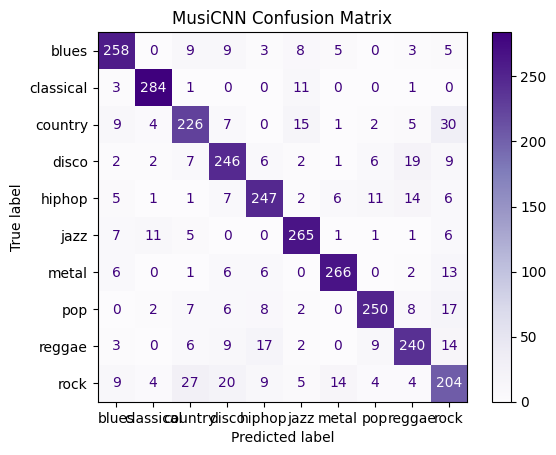

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import json

# Load data from data.json
with open('/content/sample_data/data.json', 'r') as fp:
    data = json.load(fp)

# Extract MFCCs and labels
mfccs = data['mfcc']
labels = data['genre_num']

# Validate and align data to fix sample mismatch
print(f"Original MFCCs length: {len(mfccs)}, Labels length: {len(labels)}")
min_length = min(len(mfccs), len(labels))
mfccs = mfccs[:min_length]
labels = labels[:min_length]
print(f"Aligned MFCCs length: {len(mfccs)}, Labels length: {len(labels)}")

# Convert to NumPy arrays
X = np.array(mfccs)
y = np.array(labels)

# Verify shapes
print(f"X shape: {X.shape}, y shape: {y.shape}")

# Train-validation-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

# Reshape for CNN (add channel dimension)
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]
input_shape = X_train.shape[1:4]
print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}, X_test shape: {X_test.shape}")

# Define MusiCNN model
model_musicnn = Sequential([
    # Timbral feature extraction (vertically long filters)
    Conv2D(64, (3, 7), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 1), padding='same'),
    # Temporal feature extraction (horizontally long filters)
    Conv2D(64, (7, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 1), padding='same'),
    # Additional convolutional layers for deeper feature extraction
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 1), padding='same'),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 1), padding='same'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compile model
model_musicnn.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)

# Data augmentation (vertical flip to simulate reversed audio)
datagen = ImageDataGenerator(vertical_flip=True)

# Train model
model_musicnn.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=250,
    callbacks=[early_stopping,lr_scheduler],
    verbose=1
)

# Evaluate on test set
loss, accuracy = model_musicnn.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Save model
# model_musicnn.save('models/musicnn.keras')

# Optional: Plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
y_pred = np.argmax(model_musicnn.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genres)
disp.plot(cmap='Purples')
plt.title('MusiCNN Confusion Matrix')
plt.show()

In [5]:
model_musicnn.save('musicnn.keras')

## CRNN

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout, LSTM, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Reshape

from sklearn.model_selection import train_test_split
import numpy as np
import json

# Load data
with open('/content/sample_data/data.json', 'r') as fp:
    data = json.load(fp)

# Extract MFCCs and labels
mfccs = data['mfcc']
labels = data['genre_num']

# Validate and align data
print(f"Original MFCCs length: {len(mfccs)}, Labels length: {len(labels)}")
min_length = min(len(mfccs), len(labels))
mfccs = mfccs[:min_length]
labels = labels[:min_length]
print(f"Aligned MFCCs length: {len(mfccs)}, Labels length: {len(labels)}")

# Convert to NumPy arrays
X = np.array(mfccs)
y = np.array(labels)

# Train-validation-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

# Reshape for CRNN
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]
input_shape = X_train.shape[1:4]

# Define CRNN model
model_crnn = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),
    # Reshape to (time_steps, features) for LSTM
    Reshape((-1, 128)),  # -1 infers the time dimension, 128 is the number of filters in the last Conv2D
    LSTM(64, return_sequences=False),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])
# Compile model
model_crnn.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)

# Data augmentation
datagen = ImageDataGenerator(vertical_flip=True)

# Train model
model_crnn.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_val, y_val),
    epochs=400,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate
loss, accuracy = model_crnn.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


Original MFCCs length: 9986, Labels length: 9986
Aligned MFCCs length: 9986, Labels length: 9986
Epoch 1/400


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.1764 - loss: 2.2422 - val_accuracy: 0.2747 - val_loss: 2.1468
Epoch 2/400
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.3319 - loss: 1.9593 - val_accuracy: 0.3624 - val_loss: 1.9149
Epoch 3/400
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.3894 - loss: 1.7658 - val_accuracy: 0.4468 - val_loss: 1.6769
Epoch 4/400
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.4293 - loss: 1.6530 - val_accuracy: 0.5060 - val_loss: 1.5013
Epoch 5/400
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.4760 - loss: 1.5013 - val_accuracy: 0.5370 - val_loss: 1.3714
Epoch 6/400
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5240 - loss: 1.3850 - val_accuracy: 0.5227 - val_loss: 1.3494
Epoch 7/400
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5444 - loss: 1.3086 - val_accuracy: 0.5770 - val_loss: 1.2321
Epoch 8/400
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5763 - loss: 1.2259 - val_accuracy: 0.6028 - val_l

In [ ]:
# Save model
model_crnn.save('crnn.keras')